### Predictive Maintenance for Manufacturing Machines

#### Problem Statement
###### Factories want to reduce downtime. You’ll build models that:
###### Predict whether a machine is likely to fail soon.
###### Classify the type of failure (e.g., tool wear failure (TWF), heat dissipation failure (HDF), etc.).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score

In [3]:
df = pd.read_csv(r"C:\Users\bbuser\Downloads\ai4i2020.csv")
df.shape
df.describe()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Machine failure
0    9661
1     339
Name: count, dtype: int64


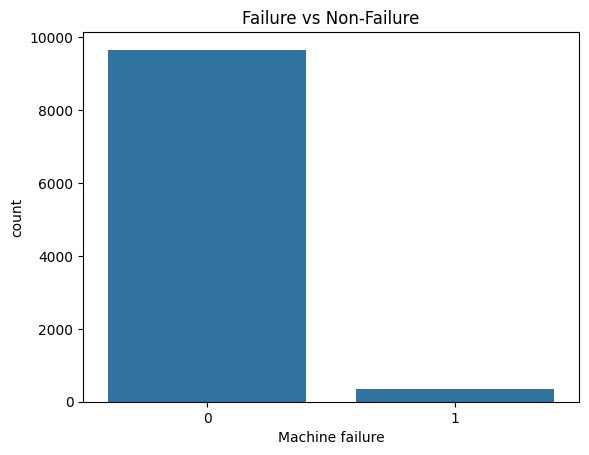

TWF     46
HDF    115
PWF     95
OSF     98
RNF     19
dtype: int64


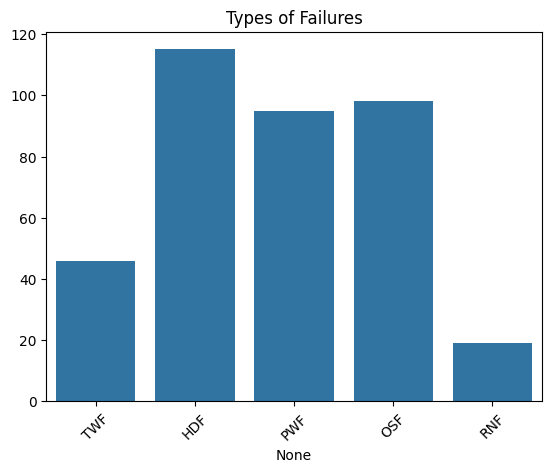

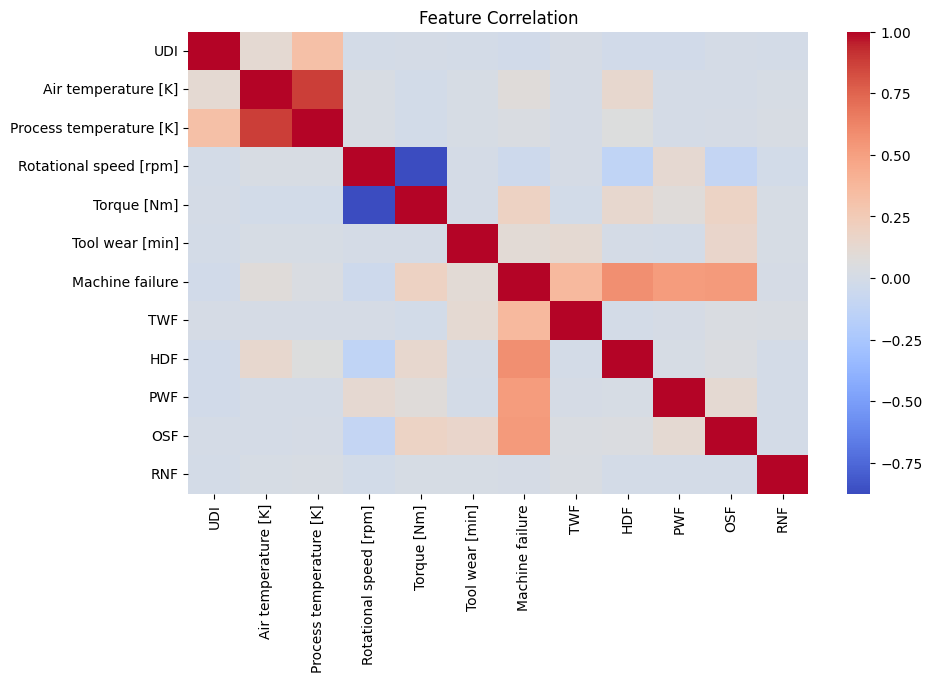

In [6]:
#EDA
print(df["Machine failure"].value_counts())
sns.countplot(x="Machine failure", data=df)
plt.title("Failure vs Non-Failure")
plt.show()

# Check failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()
print(failure_counts)
sns.barplot(x=failure_counts.index, y=failure_counts.values)
plt.xticks(rotation=45)
plt.title("Types of Failures")
plt.show()

# Correlation heatmap (numeric columns only)
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation")
plt.show()


In [8]:
#data preprocessing
features = ["Air temperature [K]", "Process temperature [K]", 
            "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

X = df[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


y1 = df["Machine failure"]      


y2 = df[failure_types].idxmax(axis=1)
y2[df[failure_types].sum(axis=1) == 0] = 'None'


##### Model 1

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Split
X_train, X_test, y1_train, y1_test = train_test_split(X_scaled, y1, test_size=0.2, stratify=y1, random_state=42)

# Models
binary_models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

print("=== Model 1: Failure Prediction ===\n")
for name, model in binary_models.items():
    model.fit(X_train, y1_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Report:")
    print(classification_report(y1_test, y_pred, digits=3))
    
    # Precision-Recall is important
    from sklearn.metrics import average_precision_score
    ap = average_precision_score(y1_test, model.predict_proba(X_test)[:,1])
    print(f"Avg Precision (PR AUC): {ap:.3f}")


=== Model 1: Failure Prediction ===


Random Forest Report:
              precision    recall  f1-score   support

           0      0.989     0.997     0.993      1932
           1      0.885     0.676     0.767        68

    accuracy                          0.986      2000
   macro avg      0.937     0.837     0.880      2000
weighted avg      0.985     0.986     0.985      2000

Avg Precision (PR AUC): 0.812

Gradient Boosting Report:
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      1932
           1      0.863     0.647     0.739        68

    accuracy                          0.985      2000
   macro avg      0.925     0.822     0.866      2000
weighted avg      0.983     0.985     0.983      2000

Avg Precision (PR AUC): 0.790

Logistic Regression Report:
              precision    recall  f1-score   support

           0      0.970     0.997     0.984      1932
           1      0.643     0.132     0.220        68

    ac

#### model 2

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)
y2_train_encoded = le.transform(y2_train)
y2_test_encoded = le.transform(y2_test)

# Split
X_train, X_test, _, _ = train_test_split(X_scaled, y2_encoded, test_size=0.2, stratify=y2_encoded, random_state=42)

# Models
multi_models = {
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

print("\n=== Model 2: Failure Type Classification ===\n")
for name, model in multi_models.items():
    model.fit(X_train, y2_train_encoded)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Report:")
    print(classification_report(y2_test_encoded, y_pred, digits=3, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y2_test_encoded, y_pred))



=== Model 2: Failure Type Classification ===


Decision Tree Report:
              precision    recall  f1-score   support

         HDF      0.821     1.000     0.902        23
        None      0.989     0.991     0.990      1930
         OSF      0.375     0.375     0.375        16
         PWF      1.000     0.833     0.909        18
         RNF      0.000     0.000     0.000         4
         TWF      0.200     0.111     0.143         9

    accuracy                          0.979      2000
   macro avg      0.564     0.552     0.553      2000
weighted avg      0.976     0.979     0.977      2000

Confusion Matrix:
 [[  23    0    0    0    0    0]
 [   4 1912    8    0    2    4]
 [   1    9    6    0    0    0]
 [   0    3    0   15    0    0]
 [   0    4    0    0    0    0]
 [   0    6    2    0    0    1]]

SVM Report:
              precision    recall  f1-score   support

         HDF      1.000     0.130     0.231        23
        None      0.974     0.999     0.986    

c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `


XGBoost Report:
              precision    recall  f1-score   support

         HDF      0.955     0.913     0.933        23
        None      0.988     0.995     0.992      1930
         OSF      0.588     0.625     0.606        16
         PWF      0.875     0.778     0.824        18
         RNF      0.000     0.000     0.000         4
         TWF      0.000     0.000     0.000         9

    accuracy                          0.983      2000
   macro avg      0.568     0.552     0.559      2000
weighted avg      0.977     0.983     0.980      2000

Confusion Matrix:
 [[  21    2    0    0    0    0]
 [   1 1921    5    2    0    1]
 [   0    6   10    0    0    0]
 [   0    4    0   14    0    0]
 [   0    4    0    0    0    0]
 [   0    7    2    0    0    0]]


c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bbuser\Desktop\DataSience-brain-bytes\DataScience-Brain-Bytes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `